# Capstone project: Clustering capitals in Brazil

In [55]:
import pandas as pd
import numpy as np
import json
import io
from pandas.io.json import json_normalize

#!pip install folium
import folium

import requests

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from collections import Counter

%matplotlib inline

### Gathering the data

In [4]:
#Getting the json file available on github
!wget -q -O 'brazil_cities.json' https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/master/json/municipios.json

with io.open('brazil_cities.json', 'r', encoding='utf-8-sig') as json_file:  
    brazil_cities_js = json.load(json_file)

##### Transforming the data into a pandas dataframe

In [5]:
brazil_cities = json_normalize(brazil_cities_js)
print(brazil_cities.shape)
brazil_cities.head()

(5570, 6)


,capital,codigo_ibge,codigo_uf,latitude,longitude,nome
0,False,5200050,52,-16.75730,-49.4412,Abadia de Goiás
1,False,3100104,31,-18.48310,-47.3916,Abadia dos Dourados
2,False,5200100,52,-16.19700,-48.7057,Abadiânia
3,False,3100203,31,-19.15510,-45.4444,Abaeté
4,False,1500107,15,-1.72183,-48.8788,Abaetetuba


##### Let's get only the cities that are capital of their states 

In [6]:
capital_cities = brazil_cities[brazil_cities['capital'] == True].reset_index(drop=True)
capital_cities

,capital,codigo_ibge,codigo_uf,latitude,longitude,nome
0,True,2800308,28,-10.909100,-37.0677,Aracaju
1,True,1501402,15,-1.455400,-48.4898,Belém
2,True,3106200,31,-19.910200,-43.9266,Belo Horizonte
3,True,1400100,14,2.823840,-60.6753,Boa Vista
4,True,5300108,53,-15.779500,-47.9297,Brasília
5,True,5002704,50,-20.448600,-54.6295,Campo Grande
6,True,5103403,51,-15.601000,-56.0974,Cuiabá
7,True,4106902,41,-25.419500,-49.2646,Curitiba
8,True,4205407,42,-27.594500,-48.5477,Florianópolis
9,True,2304400,23,-3.716640,-38.5423,Fortaleza


##### Let's also remove the first 3 columns, rename the column "nome" to City and bring it to the first position

In [7]:
capital_cities.drop(['capital', 'codigo_ibge', 'codigo_uf'], axis=1, inplace=True)
capital_cities.rename(columns={'nome': 'City'}, inplace=True)
capital_cities = capital_cities[['City', 'latitude', 'longitude']]
capital_cities.head()

,City,latitude,longitude
0,Aracaju,-10.90910,-37.0677
1,Belém,-1.45540,-48.4898
2,Belo Horizonte,-19.91020,-43.9266
3,Boa Vista,2.82384,-60.6753
4,Brasília,-15.77950,-47.9297


### Plotting the map of Brazil with capitals superimposed on top

In [8]:
#Latitude and longitude of Brazil
latitude = -14.235
longitude = -51.9253

map_brazil = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, city in zip(capital_cities['latitude'], capital_cities['longitude'], capital_cities['City']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brazil)  
    
map_brazil

##### Foursquare credentials

In [9]:
# The code was removed by Watson Studio for sharing.

### Getting the top 100 recommended venues for each capital

In [10]:
def getVenues(cities, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(cities, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(venues)

In [81]:
capitals_venues1 = getVenues(cities=capital_cities['City'], latitudes=capital_cities['latitude'], longitudes=capital_cities['longitude'],
                            radius=10000, LIMIT=100 )

In [82]:
capitals_venues1.head()

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aracaju,-10.9091,-37.0677,O Arrumadinho,-10.899554,-37.051333,Brazilian Restaurant
1,Aracaju,-10.9091,-37.0677,Museu da Gente Sergipana,-10.917090,-37.047771,History Museum
2,Aracaju,-10.9091,-37.0677,Aeroclube de Aracaju,-10.904835,-37.084486,Airport
3,Aracaju,-10.9091,-37.0677,Colina do Sto. Antônio,-10.894203,-37.059898,Scenic Lookout
4,Aracaju,-10.9091,-37.0677,Panificação Ideal,-10.904013,-37.056891,Breakfast Spot


##### Unique venue categories and their count

In [83]:
capitals_venues1['Venue Category'].value_counts()

Brazilian Restaurant             137
Ice Cream Shop                   114
Restaurant                        92
Bar                               88
Gym / Fitness Center              87
Pizza Place                       76
Café                              72
Bakery                            62
Italian Restaurant                60
Burger Joint                      59
Hotel                             58
Plaza                             58
Gym                               54
Coffee Shop                       52
Dessert Shop                      47
Snack Place                       47
Theater                           47
Park                              45
Bookstore                         39
Japanese Restaurant               38
Sandwich Place                    35
BBQ Joint                         34
Seafood Restaurant                31
Pharmacy                          29
Middle Eastern Restaurant         28
Steakhouse                        27
Sushi Restaurant                  25
C

##### I've decided to remove some categories because they are not useful for distinguishing the cities

In [100]:
capitals_venues = capitals_venues1[~capitals_venues1['Venue Category'].isin(['Brazilian Restaurant', 'Restaurant', 'Bar', 'Café', 'Coffee Shop',
                                                                           'Gym / Fitness Center', 'Pharmacy', 'Gym', 'Hotel', 'Ice Cream Shop'])]

##### Number of venues returned  for each capital

In [101]:
capitals_venues.groupby(by='City').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aracaju,60,60,60,60,60,60
Belo Horizonte,73,73,73,73,73,73
Belém,67,67,67,67,67,67
Boa Vista,76,76,76,76,76,76
Brasília,70,70,70,70,70,70
Campo Grande,69,69,69,69,69,69
Cuiabá,67,67,67,67,67,67
Curitiba,73,73,73,73,73,73
Florianópolis,77,77,77,77,77,77


##### One hot encoding of Venue Category

In [102]:
venues_onehot = pd.get_dummies(capitals_venues[['Venue Category']], prefix="", prefix_sep="")

#add the column city to the new dataframe
venues_onehot['City'] = capitals_venues['City']

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]


venues_onehot.head()

,City,Acai House,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Video Store,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
1,Aracaju,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aracaju,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aracaju,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aracaju,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Aracaju,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Mean of each category by capital

In [103]:
capitals_mean = venues_onehot.groupby(by='City', as_index=False).mean()
capitals_mean.head()

,City,Acai House,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Video Store,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Aracaju,0.016667,0.000000,0.0,0.016667,0.0,0.0,0.0,0.016667,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Belo Horizonte,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.027397,0.0,0.0,0.0,0.0
2,Belém,0.029851,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.014925,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Boa Vista,0.000000,0.013158,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Brasília,0.028571,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.014286,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


##### Top 10 most common venues for each capital

In [104]:
#function to sort the venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [105]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
capitals_venues_sorted = pd.DataFrame(columns=columns)
capitals_venues_sorted['City'] = capitals_mean['City']

for ind in np.arange(capitals_mean.shape[0]):
    capitals_venues_sorted.iloc[ind, 1:] = return_most_common_venues(capitals_mean.iloc[ind, :], num_top_venues)

capitals_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aracaju,Bakery,Bookstore,Northeastern Brazilian Restaurant,Italian Restaurant,Park,Music Venue,Burger Joint,Snack Place,BBQ Joint,Sandwich Place
1,Belo Horizonte,Pizza Place,Theater,Italian Restaurant,Steakhouse,Plaza,Snack Place,Candy Store,Supermarket,Bakery,Deli / Bodega
2,Belém,Dessert Shop,Plaza,Italian Restaurant,Pub,Acai House,Theater,Park,Bakery,Church,Food Truck
3,Boa Vista,Plaza,Snack Place,BBQ Joint,Park,Pet Store,Pizza Place,Clothing Store,Supermarket,Bakery,Burger Joint
4,Brasília,Food Truck,Pizza Place,Bakery,Burger Joint,Middle Eastern Restaurant,Acai House,Pastelaria,Plaza,Northeastern Brazilian Restaurant,Brewery
5,Campo Grande,Sushi Restaurant,Churrascaria,Soba Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Bakery,Pet Store,Vegetarian / Vegan Restaurant,Wine Bar
6,Cuiabá,Bakery,Dessert Shop,Steakhouse,Burger Joint,Pub,Japanese Restaurant,Churrascaria,Food Truck,Arts & Crafts Store,Italian Restaurant
7,Curitiba,Italian Restaurant,Pizza Place,Theater,Dessert Shop,Middle Eastern Restaurant,Burger Joint,Park,BBQ Joint,Supermarket,Bookstore
8,Florianópolis,Burger Joint,Pizza Place,Bakery,Italian Restaurant,Buffet,Scenic Lookout,Juice Bar,Dance Studio,Park,Seafood Restaurant
9,Fortaleza,Italian Restaurant,Acai House,Plaza,Theater,Art Gallery,Shopping Mall,Churrascaria,Beach,Pizza Place,Pedestrian Plaza


### Clustering capitals

In [106]:
capitals_clustering = capitals_mean.drop('City', axis=1)

##### Elbow method to select the best K (Number of clusters) for K-means

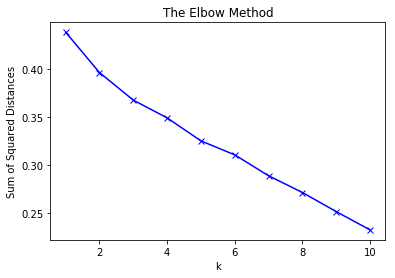

In [107]:
ssd = []
ks = range(1, 11)
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(capitals_clustering)
    ssd.append(km.inertia_)
    
plt.plot(ks, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('The Elbow Method')
plt.show()

##### As the result of the chart is not conclusive, let's use the number of regions in Brazil as K, which is 5

In [116]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=15)
kmeans.fit(capitals_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

##### Let's create a new dataframe that includes the city, latitude and longitude, the top 10 most common venues and the cluster label

In [117]:
capitals_clustered = pd.concat([capital_cities, capitals_venues_sorted.drop('City', axis=1)], axis=1)
capitals_clustered['Cluster Label'] = kmeans.labels_
capitals_clustered

,City,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
0,Aracaju,-10.909100,-37.0677,Bakery,Bookstore,Northeastern Brazilian Restaurant,Italian Restaurant,Park,Music Venue,Burger Joint,Snack Place,BBQ Joint,Sandwich Place,2
1,Belém,-1.455400,-48.4898,Pizza Place,Theater,Italian Restaurant,Steakhouse,Plaza,Snack Place,Candy Store,Supermarket,Bakery,Deli / Bodega,1
2,Belo Horizonte,-19.910200,-43.9266,Dessert Shop,Plaza,Italian Restaurant,Pub,Acai House,Theater,Park,Bakery,Church,Food Truck,1
3,Boa Vista,2.823840,-60.6753,Plaza,Snack Place,BBQ Joint,Park,Pet Store,Pizza Place,Clothing Store,Supermarket,Bakery,Burger Joint,3
4,Brasília,-15.779500,-47.9297,Food Truck,Pizza Place,Bakery,Burger Joint,Middle Eastern Restaurant,Acai House,Pastelaria,Plaza,Northeastern Brazilian Restaurant,Brewery,2
5,Campo Grande,-20.448600,-54.6295,Sushi Restaurant,Churrascaria,Soba Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Bakery,Pet Store,Vegetarian / Vegan Restaurant,Wine Bar,2
6,Cuiabá,-15.601000,-56.0974,Bakery,Dessert Shop,Steakhouse,Burger Joint,Pub,Japanese Restaurant,Churrascaria,Food Truck,Arts & Crafts Store,Italian Restaurant,4
7,Curitiba,-25.419500,-49.2646,Italian Restaurant,Pizza Place,Theater,Dessert Shop,Middle Eastern Restaurant,Burger Joint,Park,BBQ Joint,Supermarket,Bookstore,1
8,Florianópolis,-27.594500,-48.5477,Burger Joint,Pizza Place,Bakery,Italian Restaurant,Buffet,Scenic Lookout,Juice Bar,Dance Studio,Park,Seafood Restaurant,2
9,Fortaleza,-3.716640,-38.5423,Italian Restaurant,Acai House,Plaza,Theater,Art Gallery,Shopping Mall,Churrascaria,Beach,Pizza Place,Pedestrian Plaza,1


##### Let's visualize the clusters

In [118]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(capitals_clustered['latitude'], capitals_clustered['longitude'], capitals_clustered['City'], capitals_clustered['Cluster Label']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining each cluster

#### Cluster 1:

In [119]:
cluster1 = capitals_clustered[capitals_clustered['Cluster Label'] == 0]
print('Capitals in this cluster: \n')
print(list(cluster1.City))
ct = Counter(list(cluster1.drop(['City', 'latitude', 'longitude', 'Cluster Label'], axis=1).values.reshape(-1)))
print('\nTop 5 most common venue among the cluster: \n')
print(ct.most_common(5))

Capitals in this cluster: 

['Goiânia', 'Macapá', 'Manaus', 'Palmas', 'Porto Velho', 'Teresina']

Top 5 most common venue among the cluster: 

[('Pizza Place', 5), ('Snack Place', 5), ('Dessert Shop', 4), ('Burger Joint', 4), ('BBQ Joint', 4)]


#### Cluster 2:

In [120]:
cluster2 = capitals_clustered[capitals_clustered['Cluster Label'] == 1]
print('Capitals in this cluster: \n')
print(list(cluster2.City))
ct = Counter(list(cluster2.drop(['City', 'latitude', 'longitude', 'Cluster Label'], axis=1).values.reshape(-1)))
print('\nTop 5 most common venue among the cluster: \n')
print(ct.most_common(5))

Capitals in this cluster: 

['Belém', 'Belo Horizonte', 'Curitiba', 'Fortaleza', 'Rio de Janeiro', 'Salvador', 'São Paulo', 'Vitória']

Top 5 most common venue among the cluster: 

[('Italian Restaurant', 7), ('Theater', 6), ('Plaza', 5), ('Pizza Place', 5), ('Park', 5)]


#### Cluster 3:

In [121]:
cluster3 = capitals_clustered[capitals_clustered['Cluster Label'] == 2]
print('Capitals in this cluster: \n')
print(list(cluster3.City))
ct = Counter(list(cluster3.drop(['City', 'latitude', 'longitude', 'Cluster Label'], axis=1).values.reshape(-1)))
print('\nTop 5 most common venue among the cluster: \n')
print(ct.most_common(5))

Capitals in this cluster: 

['Aracaju', 'Brasília', 'Campo Grande', 'Florianópolis', 'Porto Alegre', 'Recife']

Top 5 most common venue among the cluster: 

[('Burger Joint', 6), ('Pizza Place', 5), ('Bakery', 5), ('Italian Restaurant', 4), ('Northeastern Brazilian Restaurant', 3)]


#### Cluster 4:

In [122]:
cluster4 = capitals_clustered[capitals_clustered['Cluster Label'] == 3]
print('Capitals in this cluster: \n')
print(list(cluster4.City))
ct = Counter(list(cluster4.drop(['City', 'latitude', 'longitude', 'Cluster Label'], axis=1).values.reshape(-1)))
print('\nTop 5 most common venue among the cluster: \n')
print(ct.most_common(5))

Capitals in this cluster: 

['Boa Vista', 'João Pessoa', 'Rio Branco', 'São Luís']

Top 5 most common venue among the cluster: 

[('Bakery', 3), ('Plaza', 3), ('Seafood Restaurant', 3), ('Snack Place', 3), ('Burger Joint', 2)]


#### Cluster 5:

In [123]:
cluster5 = capitals_clustered[capitals_clustered['Cluster Label'] == 4]
print('Capitals in this cluster: \n')
print(list(cluster5.City))
ct = Counter(list(cluster5.drop(['City', 'latitude', 'longitude', 'Cluster Label'], axis=1).values.reshape(-1)))
ct.most_common(5)
print('\nTop 5 most common venue among the cluster: \n')
print(ct.most_common(5))

Capitals in this cluster: 

['Cuiabá', 'Maceió', 'Natal']

Top 5 most common venue among the cluster: 

[('Dessert Shop', 3), ('Italian Restaurant', 3), ('Bakery', 3), ('Burger Joint', 3), ('Japanese Restaurant', 2)]
